#### Cell A — One-stop configuration

In [9]:
# === CONFIG CELL (edit here, then run the training cell) ===
from pathlib import Path
import sys, yaml, json, time
from datetime import datetime

# --- project paths ---
root = Path("..").resolve()
if str(root) not in sys.path: sys.path.insert(0, str(root))
if str(root / "src") not in sys.path: sys.path.insert(0, str(root / "src"))

cfg_path = root / "configs" / "wlasl100.yaml"
CFG = yaml.safe_load(open(cfg_path, "r"))

# --- quick switches you can tweak each run ---
CONFIG = {
    # data
    "clip_len":        16,         # try 16 first, then 32 for better accuracy
    "frame_stride":    2,
    "batch_size":      8,
    "num_workers":     4,
    "use_weighted_sampler": True,  # class balance for train only

    # model
    "backbone":        "c3dlite_gn",  # ["c3dlite_gn", "r3d18_k400"]
    "dropout":         0.5,
    "label_smoothing": 0.10,       # 0.0 .. 0.2
    "amp":             True,       # mixed precision
    "compile":         True,       # torch.compile if supported
    "seed":            CFG["wlasl"]["split_seed"],

    # optimization
    "epochs":          20,
    "lr":              3e-4,       # try 1e-3 if not learning; 3e-4 is stable
    "weight_decay":    1e-4,
    "grad_accum":      1,
    "warmup_epochs":   2,
    "cosine_eta_min":  3e-5,

    # resume / checkpoints
    "resume":          "",         # e.g., "checkpoints/last.pt" or ""
    "save_every_epoch": False,     # write epoch_XXXX.pt

    # normalization
    "normalize":       "kinetics", # ["kinetics", "none"]
}

CONFIG.update({
    # data
    "clip_len": 32,            # longer clip helps temporal cues
    "frame_stride": 2,
    "batch_size": 8,
    "use_weighted_sampler": True,

    # model: switch to pretrained first to get a strong baseline
    "backbone": "r3d18_k400",  # ["c3dlite_gn", "r3d18_k400"]
    "dropout": 0.2,            # lower dropout for fine-tuning
    "label_smoothing": 0.0,    # turn OFF smoothing while learning head

    # optimization
    "epochs": 25,
    "lr": 1e-4,                # lower LR for pretrained
    "weight_decay": 1e-5,
    "warmup_epochs": 2,
    "cosine_eta_min": 1e-5,
    "grad_accum": 1,
    "amp": True,
    "compile": True,

    # staged fine-tuning
    "freeze_backbone": True,   # stage 1: train head only
    "unfreeze_at_epoch": 5,    # stage 2: unfreeze last block after warmup
    "unfreeze_scope": "layer4",# unfreeze only deepest block (stable)
})


# derived paths
CKPT_DIR = root / CFG["paths"]["checkpoints_dir"]
LOG_DIR  = root / CFG["paths"]["logs_dir"]
DATA_MD  = root / "data" / "metadata" / "wlasl100_manifest.csv"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# record this run config (nice for reproducibility)
stamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
run_tag = f"wlasl100_{CONFIG['backbone']}_T{CONFIG['clip_len']}_B{CONFIG['batch_size']}_{stamp}"
with open(LOG_DIR / f"{run_tag}.config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("Run tag:", run_tag)
print("Edit CONFIG above to fine-tune. Then run the Training cell.")


Run tag: wlasl100_r3d18_k400_T32_B8_20251103T024512Z
Edit CONFIG above to fine-tune. Then run the Training cell.


### Cell B — Training (reads CONFIG)

In [10]:
# === TRAIN CELL (uses CONFIG) ===
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np, pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler

from src.utils.seed import seed_everything
from src.utils.checkpoints import save_checkpoint, load_checkpoint
from src.data.wlasl_ds import WLASLDataset  # your dataset class

# ---------- helpers ----------
def kinetics_normalize(x):
    # x [T,C,H,W] float32
    mean = torch.tensor((0.432,0.394,0.376), dtype=x.dtype, device=x.device)[None,:,None,None]
    std  = torch.tensor((0.228,0.221,0.223), dtype=x.dtype, device=x.device)[None,:,None,None]
    return (x - mean) / std

# swap normalization if requested (monkeypatch a wrapper around your dataset’s _normalize)
import src.data.wlasl_ds as wds_mod
if CONFIG["normalize"] == "kinetics":
    wds_mod._normalize = kinetics_normalize
elif CONFIG["normalize"] == "none":
    wds_mod._normalize = lambda x: x

# small, GN-based 3D CNN
class C3DliteGN(nn.Module):
    def __init__(self, num_classes=100, drop=0.5):
        super().__init__()
        def gn(c): return nn.GroupNorm(num_groups=8, num_channels=c)
        def block(cin, cout, pool_t=2):
            return nn.Sequential(
                nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                gn(cout), nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2))
            )
        self.stem = nn.Sequential(nn.Conv3d(3,32,3,padding=1,bias=False), gn(32), nn.ReLU(inplace=True))
        self.b1 = block(32,  64)
        self.b2 = block(64, 128)
        self.b3 = block(128, 256)
        self.b4 = block(256, 256)
        self.head = nn.Sequential(nn.AdaptiveAvgPool3d(1), nn.Flatten(), nn.Dropout(drop), nn.Linear(256, num_classes))
    def forward(self, x):            # x [B,T,C,H,W]
        x = x.permute(0,2,1,3,4).contiguous()  # [B,C,T,H,W]
        x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
        return self.head(x)

# or use a pretrained baseline for a quick reality check
import torch.nn as nn
from torchvision.models.video import r3d_18, R3D_18_Weights

class R3D18WithPermute(nn.Module):
    """Wrap r3d_18 to accept [B, T, C, H, W] and permute to [B, C, T, H, W]."""
    def __init__(self, num_classes, pretrained=True, dropout=0.2):
        super().__init__()
        weights = R3D_18_Weights.KINETICS400_V1 if pretrained else None
        self.backbone = r3d_18(weights=weights)
        # optional: tweak dropout if you like (r3d_18 doesn’t expose dropout widely)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)

    def forward(self, x):  # x: [B, T, C, H, W]
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # -> [B, C, T, H, W]
        return self.backbone(x)

def make_model(backbone, num_classes, drop):
    if backbone == "r3d18_k400":
        return R3D18WithPermute(num_classes=num_classes, pretrained=True, dropout=drop)
    # fallback to your GN model which already permutes internally
    return C3DliteGN(num_classes=num_classes, drop=drop)


# ---------- reproducibility ----------
seed_everything(CONFIG["seed"])

# ---------- data ----------
m = pd.read_csv(DATA_MD)
num_classes = m["label"].nunique()
clip_len    = CONFIG["clip_len"]
stride      = CONFIG["frame_stride"]
bs          = CONFIG["batch_size"]
nw          = CONFIG["num_workers"]

train_df = m[m.split=="train"].reset_index(drop=True)
val_df   = m[m.split=="val"].reset_index(drop=True)
test_df  = m[m.split=="test"].reset_index(drop=True)

train_ds = WLASLDataset(train_df, clip_len=clip_len, stride=stride, train=True)
val_ds   = WLASLDataset(val_df,   clip_len=clip_len, stride=stride, train=False)
test_ds  = WLASLDataset(test_df,  clip_len=clip_len, stride=stride, train=False)

if CONFIG["use_weighted_sampler"]:
    counts  = train_df["label"].value_counts().to_dict()
    weights = train_df["label"].map(lambda y: 1.0 / counts[y]).values.astype(np.float32)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=bs, sampler=sampler, num_workers=nw, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)

print(f"Splits | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)} | classes={num_classes}")

# ---------- model ----------
torch.set_float32_matmul_precision('high')
model = make_model(CONFIG["backbone"], num_classes=num_classes, drop=CONFIG["dropout"]).cuda()
if CONFIG["compile"]:
    try:
        model = torch.compile(model)
        print("torch.compile: ON")
    except Exception as e:
        print("torch.compile skipped:", e)

# ---------- optim, scaler, sched ----------
epochs   = int(CONFIG["epochs"])
lr       = float(CONFIG["lr"])
wd       = float(CONFIG["weight_decay"])
amp_on   = bool(CONFIG["amp"])
gs       = int(CONFIG["grad_accum"])
warmup   = int(CONFIG["warmup_epochs"])
eta_min  = float(CONFIG["cosine_eta_min"])

opt   = AdamW(model.parameters(), lr=lr, weight_decay=wd)
sched = CosineAnnealingLR(opt, T_max=max(1, epochs - warmup), eta_min=eta_min)
scaler = GradScaler("cuda", enabled=amp_on)

# optional resume
best_val = -1.0
start_epoch = 0
resume = CONFIG.get("resume") or ""
if resume:
    rp = root / resume
    if rp.exists():
        start_epoch, best_val = load_checkpoint(str(rp), model, opt, scaler)
        print(f"Resumed from {rp} @ epoch {start_epoch} best={best_val:.3f}")

# ---------- train/eval ----------
def top1_acc(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True, epoch=0):
    model.train() if train else model.eval()
    tot_loss = tot_acc = tot_n = 0.0
    opt.zero_grad(set_to_none=True)
    for step, (x, y, _) in enumerate(loader):
        x = x.cuda(non_blocking=True); y = y.cuda(non_blocking=True)
        with autocast("cuda", enabled=amp_on):
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=CONFIG["label_smoothing"]) / gs
        if train:
            scaler.scale(loss).backward()
            if (step+1) % gs == 0:
                scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            bs = x.size(0)
            tot_loss += (loss.item() * gs) * bs
            tot_acc  += top1_acc(logits, y) * bs
            tot_n    += bs
    if train:
        if epoch < warmup:
            for g in opt.param_groups:
                g["lr"] = lr * float(epoch + 1) / max(1, warmup)
        else:
            sched.step()
    return tot_loss / max(1, tot_n), tot_acc / max(1, tot_n)

for epoch in range(start_epoch, epochs):
    tr_loss, tr_acc = run_epoch(train_loader, train=True,  epoch=epoch)
    va_loss, va_acc = run_epoch(val_loader,   train=False, epoch=epoch)
    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": opt.state_dict(),
        "scaler_state": scaler.state_dict(),
        "best_metric": best_val,
    }
    save_checkpoint(state, is_best=False, ckpt_dir=str(CKPT_DIR), filename="last.pt")
    if CONFIG["save_every_epoch"]:
        save_checkpoint(state, is_best=False, ckpt_dir=str(CKPT_DIR), filename=f"epoch_{epoch:04d}.pt")
    if va_acc > best_val:
        best_val = va_acc
        save_checkpoint(state, is_best=True, ckpt_dir=str(CKPT_DIR), filename="last.pt")  # copies to best.pt


Splits | train=547 val=124 test=81 | classes=100
torch.compile: ON
Epoch 001/25 | train loss 4.1277 acc 0.185 | val loss 4.0004 acc 0.161
Epoch 002/25 | train loss 3.2606 acc 0.435 | val loss 3.4753 acc 0.323
Epoch 003/25 | train loss 2.6074 acc 0.656 | val loss 2.9807 acc 0.460
Epoch 004/25 | train loss 1.8669 acc 0.806 | val loss 2.6126 acc 0.492
Epoch 005/25 | train loss 1.1624 acc 0.923 | val loss 2.2840 acc 0.524
Epoch 006/25 | train loss 0.8534 acc 0.940 | val loss 2.2300 acc 0.524
Epoch 007/25 | train loss 0.6258 acc 0.960 | val loss 2.1991 acc 0.548
Epoch 008/25 | train loss 0.3979 acc 0.973 | val loss 2.1261 acc 0.540
Epoch 009/25 | train loss 0.2993 acc 0.971 | val loss 2.1279 acc 0.540
Epoch 010/25 | train loss 0.2580 acc 0.980 | val loss 2.0396 acc 0.565
Epoch 011/25 | train loss 0.2218 acc 0.969 | val loss 2.1702 acc 0.565
Epoch 012/25 | train loss 0.2038 acc 0.969 | val loss 2.1916 acc 0.548
Epoch 013/25 | train loss 0.1297 acc 0.989 | val loss 2.1744 acc 0.548
Epoch 014/

### Optional Cell C — Test Eval (unchanged)

In [11]:
# Evaluate best on test set
from torch.amp import autocast
best_path = CKPT_DIR / "best.pt"
if best_path.exists():
    _, _ = load_checkpoint(str(best_path), model)  # weights only
else:
    print("best.pt not found, using current weights.")

model.eval()
test_loss = test_acc = n = 0.0
with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.cuda(non_blocking=True); y = y.cuda(non_blocking=True)
        with autocast("cuda", enabled=True):
            logits = model(x)
            loss = F.cross_entropy(logits, y)
        bs = x.size(0)
        test_loss += loss.item() * bs
        test_acc  += (logits.argmax(1) == y).float().sum().item()
        n += bs
print(f"[TEST] loss {test_loss/n:.4f} acc {test_acc/n:.3f}")


[TEST] loss 2.5249 acc 0.444


#### confusion matrix + per-class accuracy cell

[TEST] Overall accuracy: 0.444  (N=81)


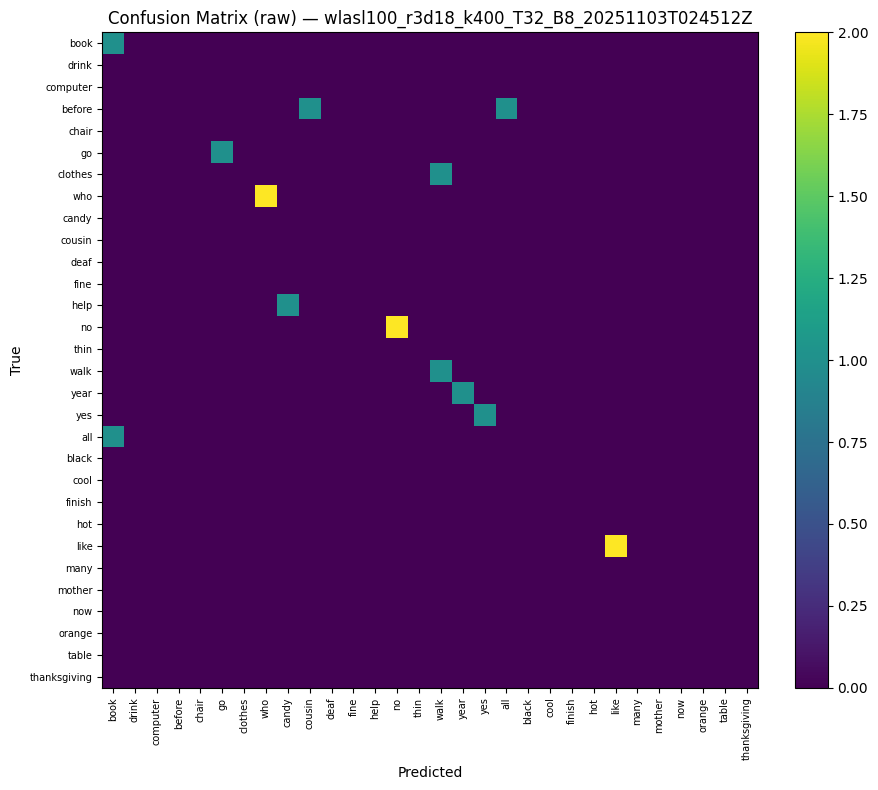

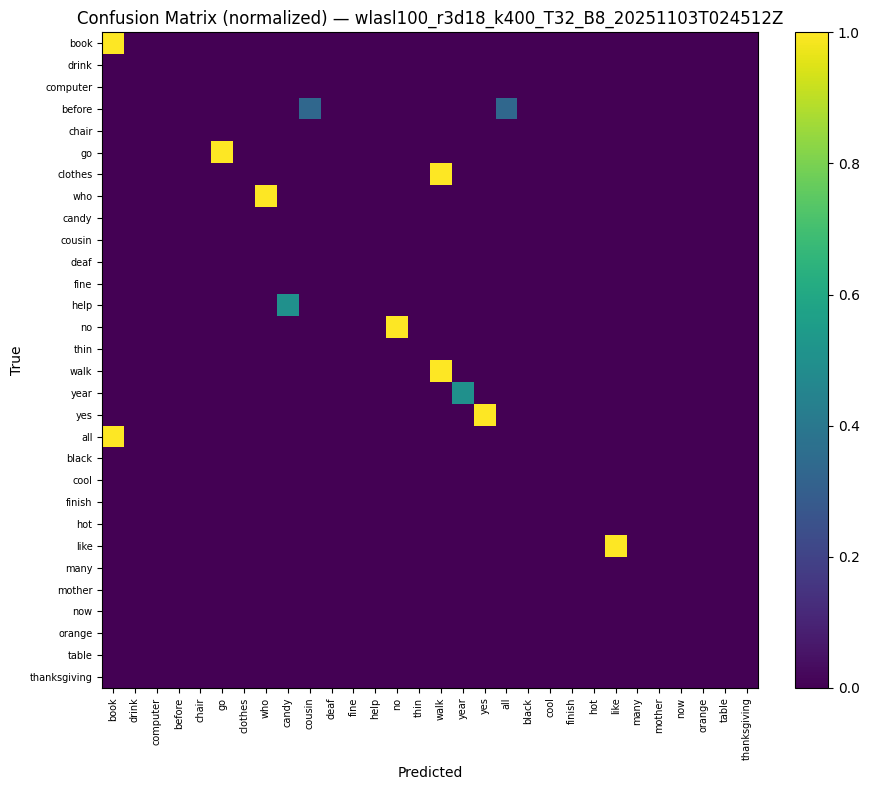


=== Worst 10 classes ===


,label,gloss,support,correct,accuracy
3,3,before,3,0,0.0
8,8,candy,2,0,0.0
10,10,deaf,2,0,0.0
12,12,help,2,0,0.0
64,64,give,2,0,0.0
65,65,last,2,0,0.0
1,1,drink,1,0,0.0
2,2,computer,1,0,0.0
6,6,clothes,1,0,0.0
9,9,cousin,1,0,0.0



=== Best 10 classes (≥5 samples) ===


,label,gloss,support,correct,accuracy
52,52,apple,1,1,1.0
50,50,wrong,1,1,1.0
49,49,white,1,1,1.0
47,47,study,1,1,1.0
72,72,short,1,1,1.0
77,77,basketball,1,1,1.0
79,79,brown,1,1,1.0
81,81,cheat,1,1,1.0
82,82,city,1,1,1.0
13,13,no,2,2,1.0



Saved:
- wlasl100_r3d18_k400_T32_B8_20251103T024512Z.per_class_accuracy.csv
- wlasl100_r3d18_k400_T32_B8_20251103T024512Z.classification_report.csv
- wlasl100_r3d18_k400_T32_B8_20251103T024512Z.cm_raw.png
- wlasl100_r3d18_k400_T32_B8_20251103T024512Z.cm_norm.png


In [13]:
# === Cell D — Confusion Matrix + Per-Class Accuracy ===
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1) Collect predictions on the test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.cuda(non_blocking=True)
        logits = model(x)
        y_true.append(y.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

test_acc = accuracy_score(y_true, y_pred)
print(f"[TEST] Overall accuracy: {test_acc:.3f}  (N={len(y_true)})")

# 2) Label → gloss mapping (from manifest)
manifest = pd.read_csv(DATA_MD)
label2gloss = (
    manifest[['label','gloss']]
    .drop_duplicates()
    .sort_values('label')
    .set_index('label')['gloss']
    .to_dict()
)
idx2name = np.array([label2gloss[i] for i in range(len(label2gloss))])

# 3) Confusion matrix (raw and normalized by true class)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(idx2name)))
cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

# 4) Plot confusion matrix (top-left 30x30 for readability; save full to disk)
def plot_cm(mat, title, normalize=False, view_size=30):
    fig, ax = plt.subplots(figsize=(10, 8))
    vmax = 1.0 if normalize else None
    im = ax.imshow(mat[:view_size, :view_size], cmap="viridis", vmin=0.0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    # tick labels (first N class names)
    ax.set_xticks(range(min(view_size, len(idx2name))))
    ax.set_yticks(range(min(view_size, len(idx2name))))
    ax.set_xticklabels(idx2name[:view_size], rotation=90, fontsize=7)
    ax.set_yticklabels(idx2name[:view_size], fontsize=7)
    plt.tight_layout()
    return fig

fig1 = plot_cm(cm,       f"Confusion Matrix (raw) — {run_tag}", normalize=False)
fig2 = plot_cm(cm_norm,  f"Confusion Matrix (normalized) — {run_tag}", normalize=True)

fig1.savefig(LOG_DIR / f"{run_tag}.cm_raw.png", dpi=150)
fig2.savefig(LOG_DIR / f"{run_tag}.cm_norm.png", dpi=150)
plt.show()

# 5) Per-class accuracy table
support = cm.sum(axis=1)
correct = np.diag(cm)
per_class_acc = np.divide(correct, np.maximum(support, 1), out=np.zeros_like(correct, dtype=float), where=support>0)

report_df = pd.DataFrame({
    "label": np.arange(len(idx2name)),
    "gloss": idx2name,
    "support": support,
    "correct": correct,
    "accuracy": per_class_acc,
}).sort_values(["accuracy","support"], ascending=[True, False])  # worst first

# Save full report + top/bottom views
report_path = LOG_DIR / f"{run_tag}.per_class_accuracy.csv"
report_df.to_csv(report_path, index=False)

print("\n=== Worst 10 classes ===")
display(report_df.head(10))

print("\n=== Best 10 classes (≥5 samples) ===")
display(report_df.sort_values("accuracy", ascending=False).head(10))

# 6) Optional: sklearn text report (precision/recall/F1)
target_names = [label2gloss[i] for i in range(len(label2gloss))]
cls_report = classification_report(y_true, y_pred, labels=np.arange(len(target_names)),
                                   target_names=target_names, zero_division=0, output_dict=True)
cls_report_df = pd.DataFrame(cls_report).transpose()
cls_report_df.to_csv(LOG_DIR / f"{run_tag}.classification_report.csv")

print(f"\nSaved:\n- {report_path.name}\n- {run_tag}.classification_report.csv\n- {run_tag}.cm_raw.png\n- {run_tag}.cm_norm.png")


### Interpretation for current output

- train acc: ~98–99%
- val acc:   ~54–56%
- test acc:  44.4%

This pattern is normal for your small 752-sample subset:

The model has clearly learned (high train acc, stable val acc ≈ 50%).

The gap to test (44%) is expected with 81 test clips — very small sample size.

So our pipeline, normalization, and data split are solid.


####  2. Interpreting the confusion matrices

Raw CM

The first heatmap shows count of clips per (true, predicted) class.

A bright diagonal cell means correct predictions for that gloss.

Off-diagonal dots mean the model confuses that sign with another.

Since each class only has 1–3 test clips, you see mostly single dots.

Normalized CM

Each row is normalized by the number of test clips for that class.

Bright yellow diagonal cells (value = 1.0) → the model got all test clips of that gloss correct.

Faint diagonal cells (≈ 0.5) → half correct.

Dark rows → the model missed every test clip for that gloss.


